# Beer Styles Predictions

Data comes from Kaggle Dataset: https://www.kaggle.com/jtrofe/beer-recipes

## Import Necessary Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Clean Data

In [2]:
#import data into dataframe
rec = pd.read_csv('./BeerRecipes/recipeData.csv', encoding = "ISO-8859-1")

In [3]:
#there are 22 columns and 73K rows
rec.shape

(73861, 22)

In [4]:
#quickly view which columns contain nulls, these are not easily imputable, and there is lots of missind data, will drop
rec.isnull().sum()

BeerID               0
Name                 1
URL                  0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
dtype: int64

In [5]:
#drop columns with lots of missing data
rec.drop(columns = ['MashThickness', 'PitchRate', 'PrimaryTemp', 'PrimingMethod', 'PrimingAmount', 'BoilGravity'], inplace = True)

In [6]:
#drop columns that won't be used in prediction, non-recipe specific columns
rec.drop(columns = ['Name', 'BeerID', 'Size(L)', 'BoilSize', 'BrewMethod', 'URL', 'SugarScale'], inplace = True)

In [7]:
#drop rows that do not have a style, this is our y(what we will predict)
rec.drop(rec[rec['Style'].isnull()].index, inplace =  True)

#### Definining Broad Categories of Beer Styles

In [8]:
#one hot encoding styles
rec['IPA'] = rec['Style'].apply(lambda x: 1 if x.find('IPA') > -1 else 0)
rec['Porter'] = rec['Style'].apply(lambda x: 1 if x.find('Porter') > -1 else 0)
rec['Stout'] = rec['Style'].apply(lambda x: 1 if x.find('Stout') > -1 else 0)
rec['Ale'] = rec['Style'].apply(lambda x: 1 if x.find('Ale') > -1 else 0)
rec['Lager'] = rec['Style'].apply(lambda x: 1 if x.find('Lager') > -1 else (1 if x.find('Pils') > -1 else 0))
rec['Witbier'] = rec['Style'].apply(lambda x: 1 if x.find('Witbier') > -1 else 0)
rec['Saison'] = rec['Style'].apply(lambda x: 1 if x.find('Saison') > -1 else 0)

In [9]:
#defined styles present in dataset
rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']].sum().sum()

53592

In [10]:
#drop styles that don't fit into pre-defined categories
rec.drop(rec[(rec['IPA'] != 1) & (rec['Porter'] != 1) & (rec['Stout'] != 1) & (rec['Ale'] != 1) & (rec['Lager'] != 1) \
                      & (rec['Witbier'] != 1) & (rec['Saison'] != 1)].index, inplace = True)

#### EDA

In [11]:
#saving count of top style, American IPA, to determine baseline accuracy
top_style = rec.groupby(by = 'Style')[['Style']].count().sort_values(by = 'Style', ascending = False).rename(columns = {'Style':'Style Count'}).reset_index().loc[0,'Style Count']

#showing counts of granular styles in dataset
rec.groupby(by = 'Style')[['Style']].count().sort_values(by = 'Style', ascending = False).rename(columns = {'Style':'Style Count'}).reset_index().tail()

,Style,Style Count
63,Czech Amber Lager,32
64,Tropical Stout,31
65,Pre-Prohibition Lager,30
66,Pre-Prohibition Porter,12
67,London Brown Ale,8


In [12]:
#dataframe showing totals of styles
style_agg = pd.DataFrame(rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']].sum(), columns = ['Style Count']).reset_index().rename(columns = {'index':'Style'}).sort_values(by = 'Style Count', ascending = False)
style_agg['percent'] = style_agg['Style Count'].apply(lambda x: x/style_agg['Style Count'].sum()*100)
style_agg

,Style,Style Count,percent
3,Ale,18859,35.189954
0,IPA,17064,31.840573
2,Stout,5954,11.109867
4,Lager,5326,9.938050
1,Porter,2700,5.038065
6,Saison,2617,4.883192
5,Witbier,1072,2.000299


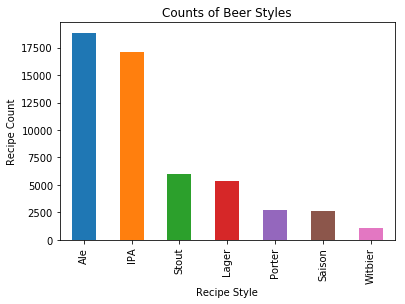

In [28]:
#plotting counts of styles
style_agg.plot(x = 'Style', y = 'Style Count', kind = 'bar', legend = False)
plt.title('Counts of Beer Styles')
plt.xlabel('Recipe Style')
plt.ylabel('Recipe Count');

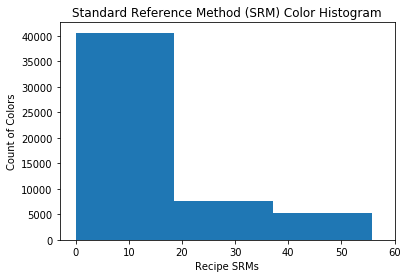

In [50]:
rec.hist(column = 'Color', grid = False)
plt.xlim(-3, 60)
plt.title('Standard Reference Method (SRM) Color Histogram')
plt.xlabel('Recipe SRMs')
plt.ylabel('Count of Colors');

## Split/prepare data for modeling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
#declare X and y
X = rec[['OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency']]
y = rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']]

In [260]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#set as numpy array
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

In [261]:
#standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Create Models

### A) CART

In [262]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [263]:
def CART_model_picker(model_list, X_train, y_train, X_test, y_test):
    '''Returns cross-val score and score for all input CART models, returns in sorted order of best performing'''
    results = []
    
    for (k,v) in model_list.items():
        scores = cross_val_score(v, X_train, y_train, cv = 5, n_jobs = -1)
        v.fit(X_train, y_train)

        results.append((k, scores.mean(), v.score(X_test, y_test)))
    
    results.sort(key = lambda x: x[2], reverse = True)
    results.insert(0, ('Model', 'Cross_val_score mean', 'Model Score R^2'))
    
    return results

In [264]:
#figure out which CART model performs the best
models = {'Decision Tree': DecisionTreeClassifier(),
          'Extra Trees': ExtraTreesClassifier(),
          'Random Forest':RandomForestClassifier()
         }

dt_results = CART_model_picker(models, X_train, y_train, X_test, y_test)
dt_results

[('Model', 'Cross_val_score mean', 'Model Score R^2'),
 ('Decision Tree', 0.5606171891858204, 0.5684786665008086),
 ('Random Forest', 0.5348138288450726, 0.5365095161089688),
 ('Extra Trees', 0.5143946367067675, 0.5225152382137082)]

### B) Neural Network

In [265]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

In [274]:
#create model
model = Sequential()

In [275]:
#network topology
input_units = X_train.shape[1]
hidden_units = X_train.shape[1] - 1

#input layer
model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu',
                kernel_regularizer=regularizers.l2(0.0001)))
#hidden layer
model.add(Dense(hidden_units, 
               activation = 'relu',))

#output layer
model.add(Dense(7, activation = 'sigmoid'))

In [276]:
#compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [277]:
#train the model
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 10, 
                   batch_size = None, 
                   verbose = 1)

Train on 37514 samples, validate on 16078 samples
Epoch 1/10
37514/37514 [==============================] - 5s 142us/step - loss: 0.3693 - binary_accuracy: 0.8385 - val_loss: 0.2611 - val_binary_accuracy: 0.8853
Epoch 2/10
37514/37514 [==============================] - 5s 123us/step - loss: 0.2524 - binary_accuracy: 0.8884 - val_loss: 0.2459 - val_binary_accuracy: 0.8921
Epoch 3/10
37514/37514 [==============================] - 4s 116us/step - loss: 0.2439 - binary_accuracy: 0.8943 - val_loss: 0.2402 - val_binary_accuracy: 0.8965
Epoch 4/10
37514/37514 [==============================] - 5s 125us/step - loss: 0.2397 - binary_accuracy: 0.8979 - val_loss: 0.2372 - val_binary_accuracy: 0.8994
Epoch 5/10
37514/37514 [==============================] - 4s 119us/step - loss: 0.2369 - binary_accuracy: 0.8994 - val_loss: 0.2346 - val_binary_accuracy: 0.9004
Epoch 6/10
37514/37514 [==============================] - 4s 116us/step - loss: 0.2348 - binary_accuracy: 0.9008 - val_loss: 0.2328 - val_bi

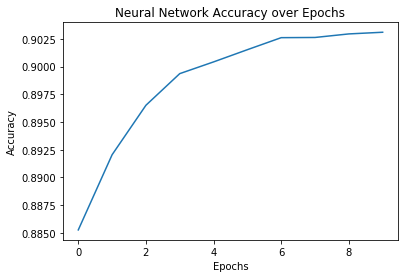

In [280]:
#plotting accuracy over epochs
plt.plot(history.history['val_binary_accuracy'])
plt.title('Neural Network Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs');

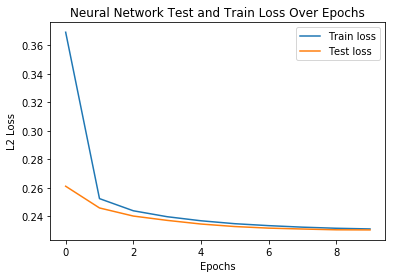

In [279]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend();
plt.title('Neural Network Test and Train Loss Over Epochs')
plt.ylabel('L2 Loss')
plt.xlabel('Epochs');